#### Task A
Create a Data Audit for the Pima Indians Diabetes Database. The audit should cover:


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis

    1. Data Overview & Structure:
			- Provide a summary of the dataset.
			- Identify the number of rows and columns.
			- List all variables names and their data types.
			- Classify each variable as categorical or numerical.	

In [12]:
df = pd.read_csv('../data/diabetes.csv')

num_rows, num_cols = df.shape

data_types = df.dtypes

categorical_vars = df.select_dtypes(include=["object"]).columns.tolist()
numerical_vars = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\n **Dataset Summary:**")
print(f" Anzahl der Zeilen: {num_rows}")
print(f" Anzahl der Spalten: {num_cols}")

print(data_types)

print("\n **Klassifizierung der Variablen:**")
print(f" Numerische Variablen ({len(numerical_vars)}): {numerical_vars}")
print(f" Kategorische Variablen ({len(categorical_vars)}): {categorical_vars}")


 **Dataset Summary:**
 Anzahl der Zeilen: 768
 Anzahl der Spalten: 9
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

 **Klassifizierung der Variablen:**
 Numerische Variablen (9): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
 Kategorische Variablen (0): []


    2. Summary Statistics:
			- Compute key statistics such as mean, median, minimum, maximum, and standard deviation.
			- Create a histogram for each variable.
   			- Identify any unusual values that stand out and possible skew of the data.

In [13]:
summary_stats = df.agg(["mean", "median", "min", "max", "std"])  # 转置让指标在左侧，更易阅读
print(summary_stats)

        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
mean       3.845052  120.894531      69.105469      20.536458   79.799479   
median     3.000000  117.000000      72.000000      23.000000   30.500000   
min        0.000000    0.000000       0.000000       0.000000    0.000000   
max       17.000000  199.000000     122.000000      99.000000  846.000000   
std        3.369578   31.972618      19.355807      15.952218  115.244002   

              BMI  DiabetesPedigreeFunction        Age   Outcome  
mean    31.992578                  0.471876  33.240885  0.348958  
median  32.000000                  0.372500  29.000000  0.000000  
min      0.000000                  0.078000  21.000000  0.000000  
max     67.100000                  2.420000  81.000000  1.000000  
std      7.884160                  0.331329  11.760232  0.476951  


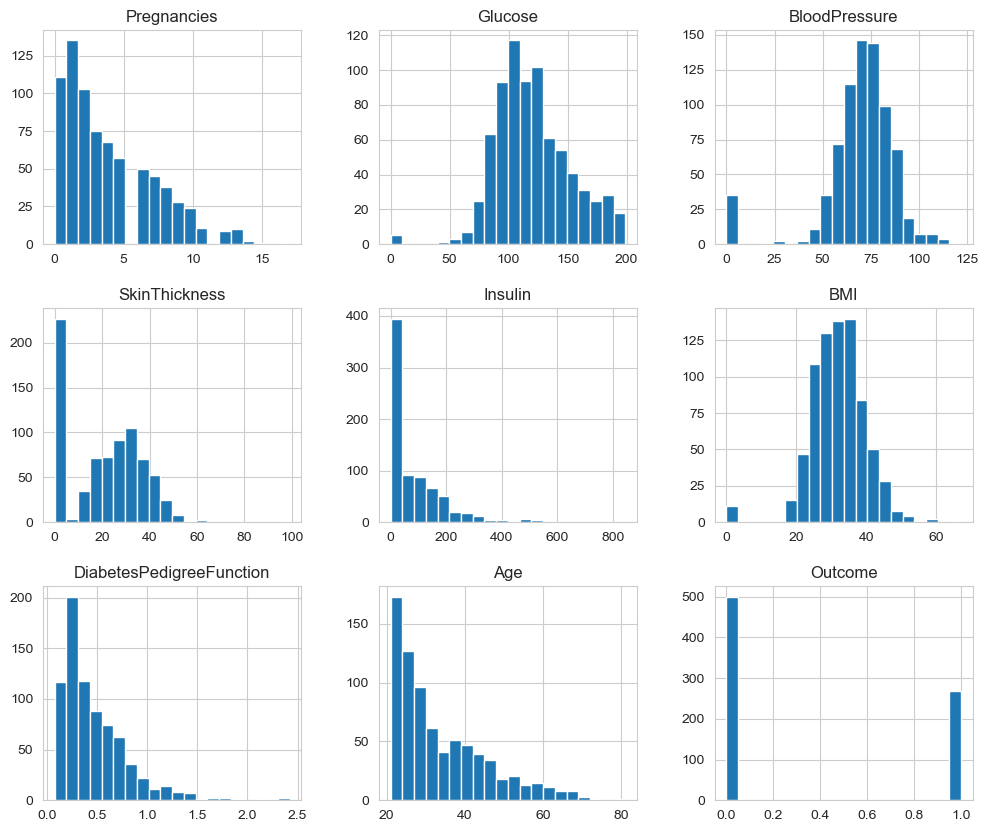

In [14]:
df.hist(figsize=(12, 10), bins=20)  # `bins=20` 控制分箱数量
plt.show()

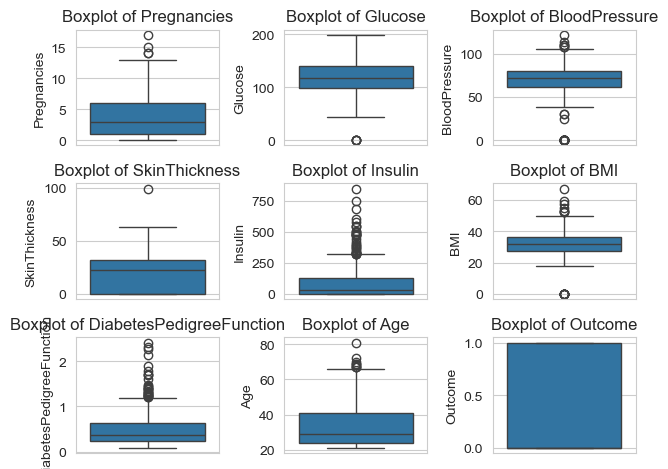

Pregnancies                 0.901674
Glucose                     0.173754
BloodPressure              -1.843608
SkinThickness               0.109372
Insulin                     2.272251
BMI                        -0.428982
DiabetesPedigreeFunction    1.919911
Age                         1.129597
Outcome                     0.635017
dtype: float64


In [15]:
# unusual value
for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

#skew
skewness = df.skew()
print(skewness)

    3. Outlier:
			- Decide on a formal method to detect univariate outliers.
			- Report the number of outliers per variable.
			- Create scatterplots for each combination of variables.
			- Can you identify possible multivariate outliers that you did not detect as univariate outliers?

---------------- OUTLIERS -------------
Number of Univariate Outliers per Variable:
Pregnancies                  4
Glucose                      5
BloodPressure               45
SkinThickness                1
Insulin                     34
BMI                         19
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64


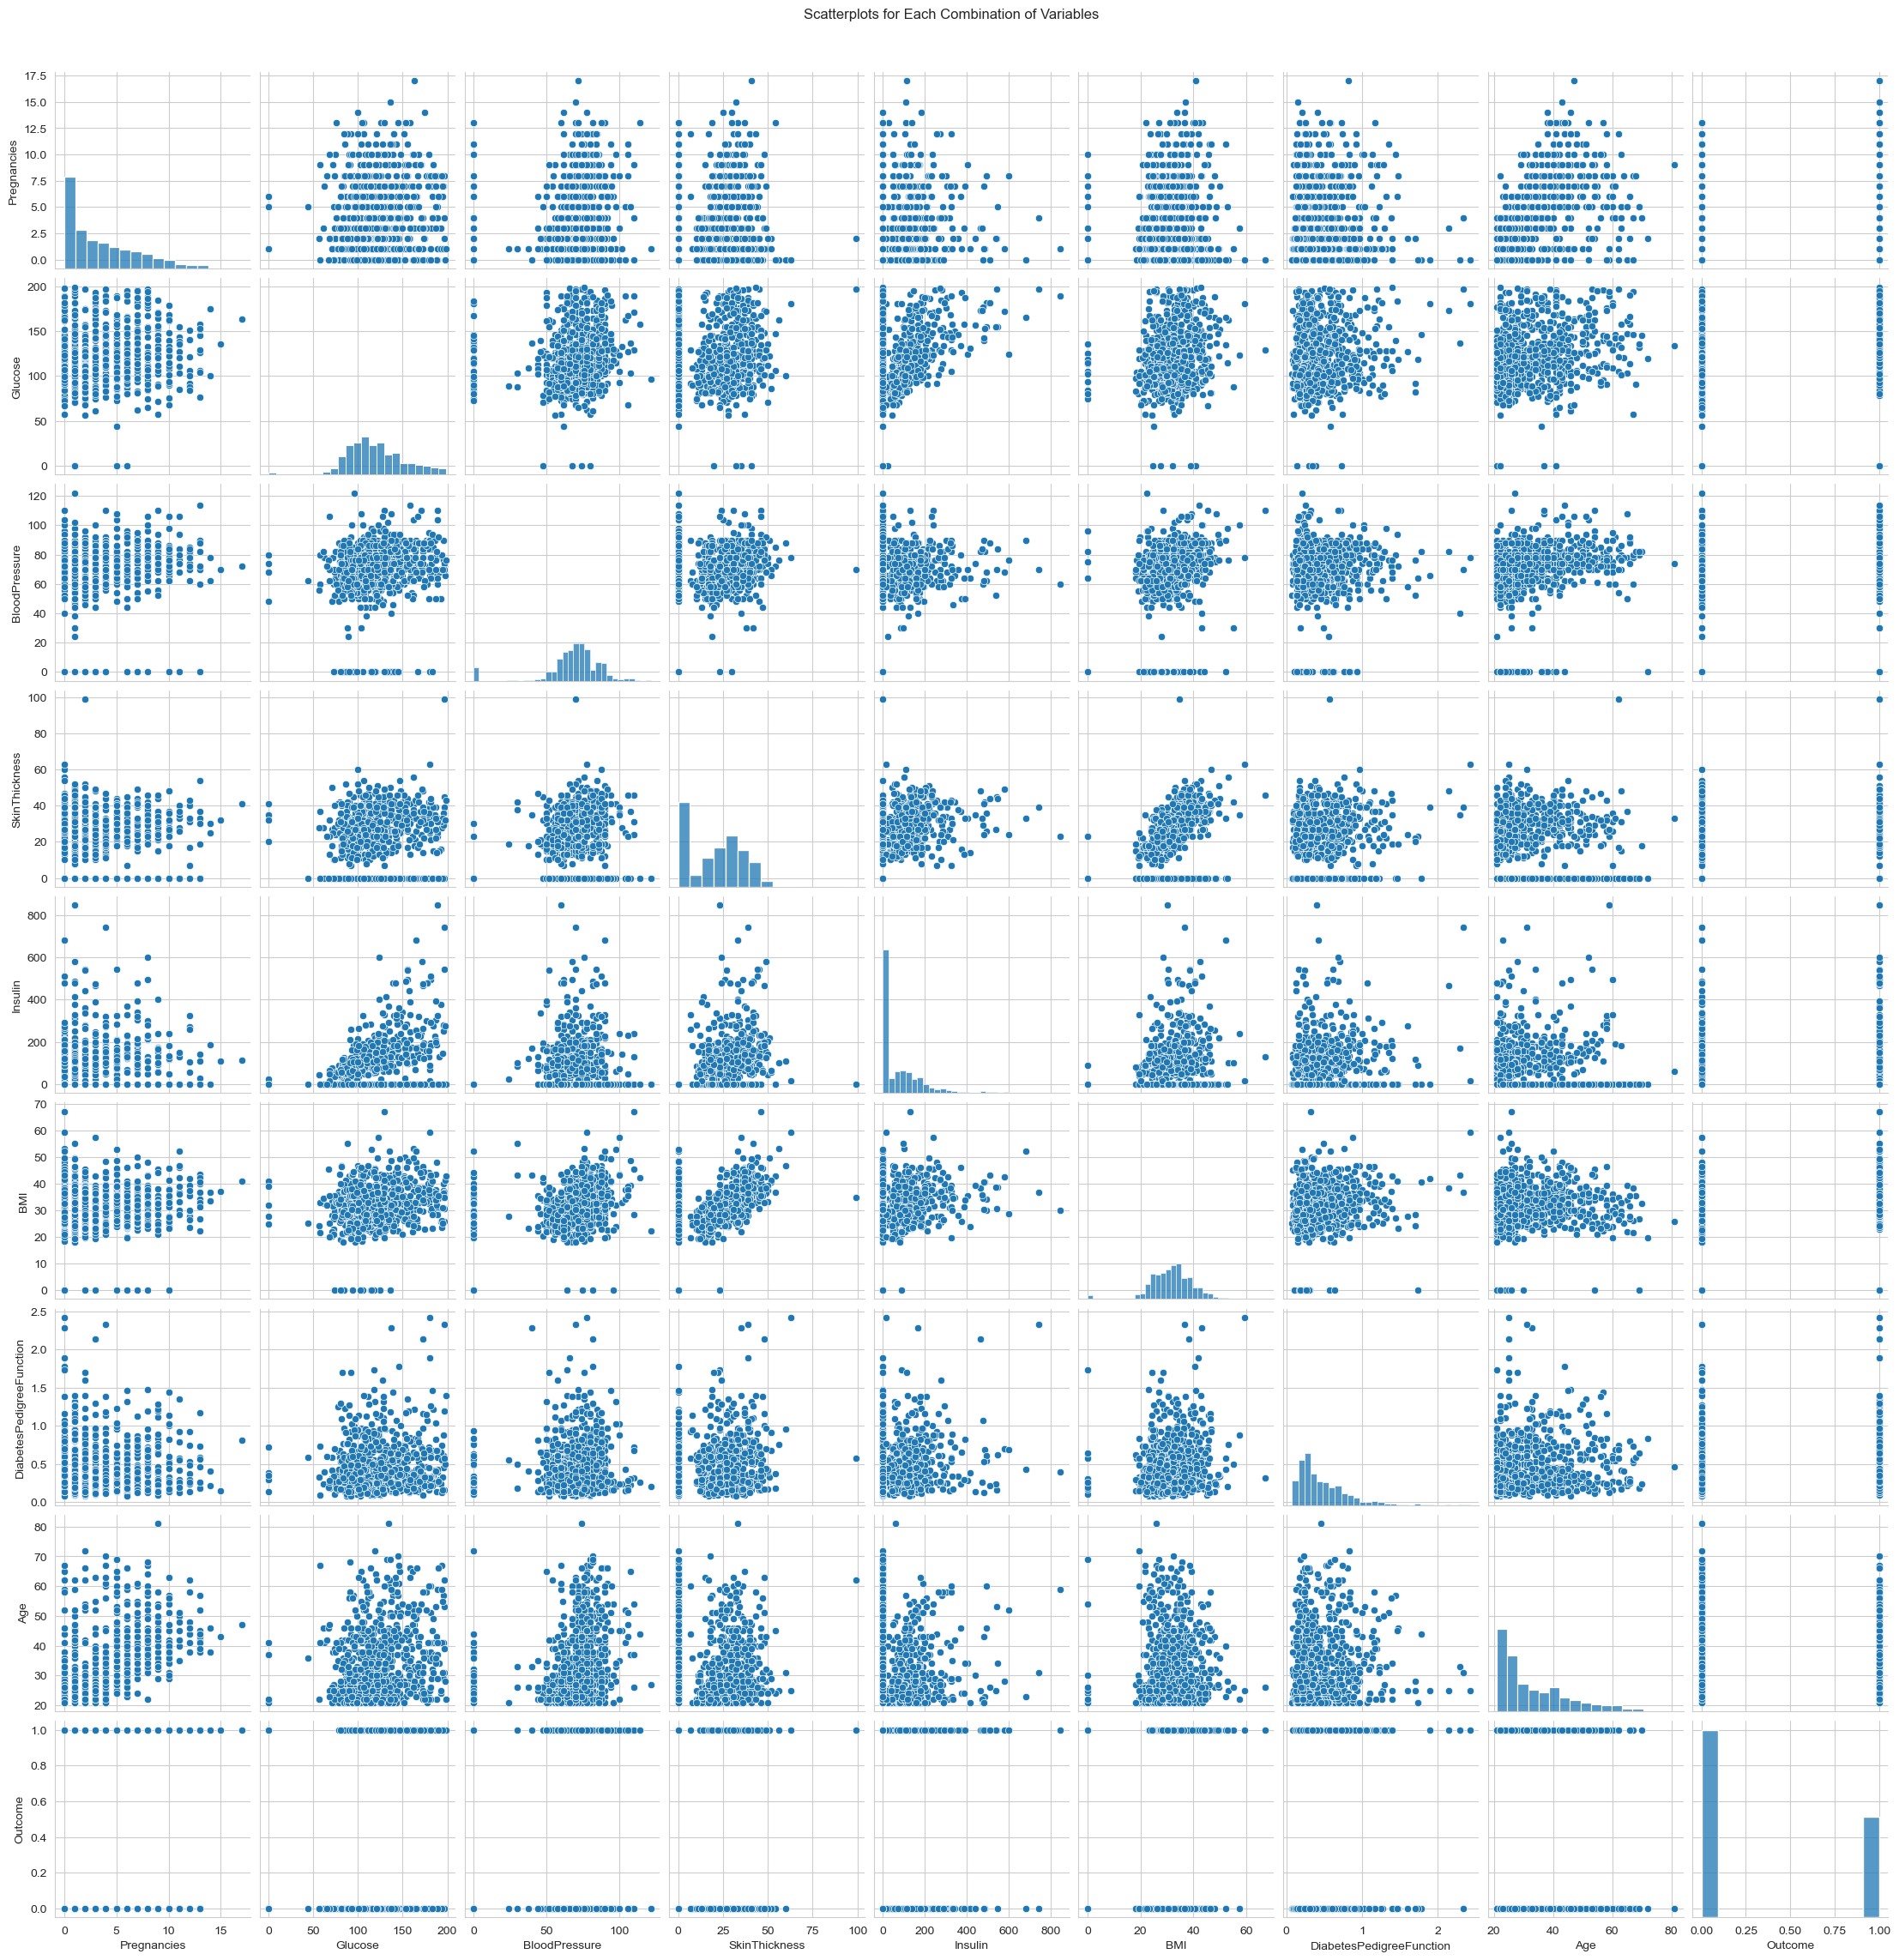

Multivariate Outliers Identified:


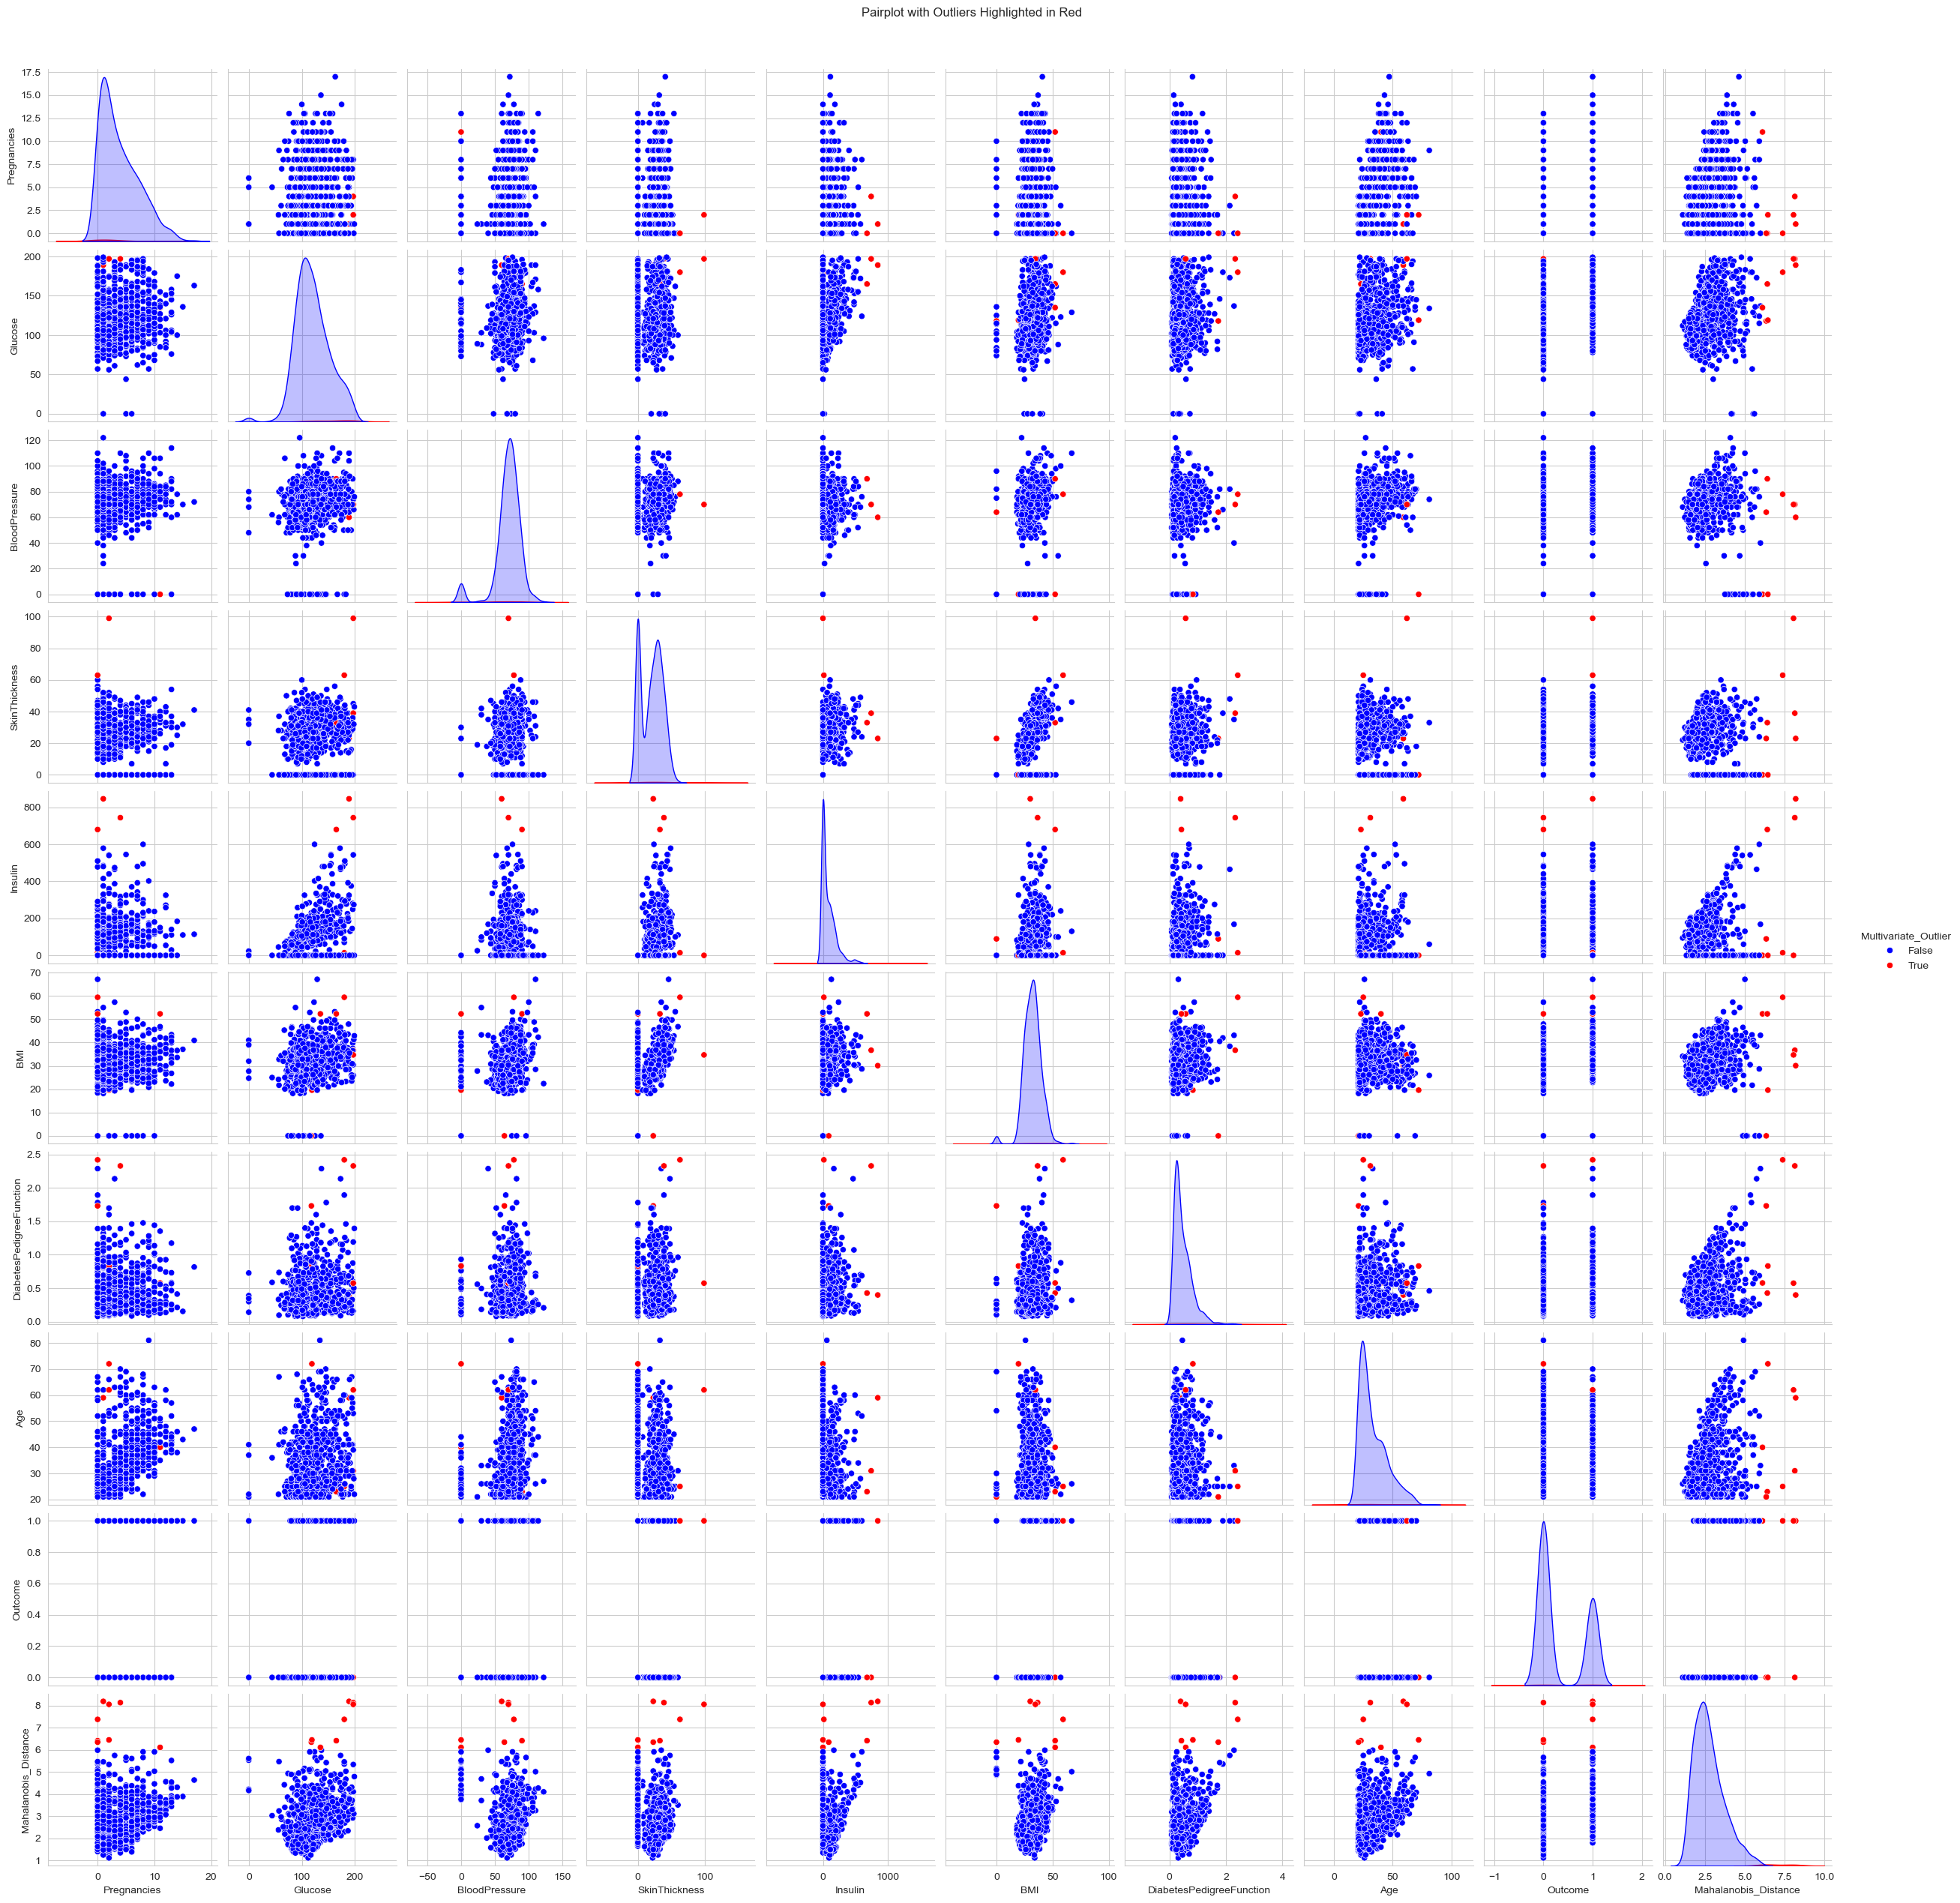

In [16]:
#
# Find Univariate Outliers
#
def detect_univariate_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

# Apply the function to each numeric column and count the outliers
outliers = df.select_dtypes(include=['float64', 'int64']).apply(detect_univariate_outliers)
outlier_counts = outliers.sum()

# Report the number of outliers per variable
print("---------------- OUTLIERS -------------")
print("Number of Univariate Outliers per Variable:")
print(outlier_counts)

#
# Scatterplots
#
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.suptitle('Scatterplots for Each Combination of Variables', y=1.02)
plt.show()

# Calculate Mahalanobis distance for each observation
def mahalanobis_distances(data):
    cov_matrix = np.cov(data.T)  # Covariance matrix
    cov_matrix_inv = np.linalg.inv(cov_matrix)  # Inverse covariance matrix
    mean_values = np.mean(data, axis=0)  # Mean of each column
    return data.apply(lambda row: mahalanobis(row, mean_values, cov_matrix_inv), axis=1)

# Apply Mahalanobis distance on numeric data
numeric_data = df.select_dtypes(include=['float64', 'int64'])
df['Mahalanobis_Distance'] = mahalanobis_distances(numeric_data)

# Define a threshold for multivariate outliers (e.g., Chi-squared distribution critical value)
threshold = 6  # Example threshold, adjust as necessary
df['Multivariate_Outlier'] = df['Mahalanobis_Distance'] > threshold

print("Multivariate Outliers Identified:")
#df['Multivariate_Outlier']
df[df['Multivariate_Outlier']]

# Create the pairplot with outliers highlighted in red
pairplot = sns.pairplot(df, diag_kind="kde", hue="Multivariate_Outlier", palette={True: 'red', False: 'blue'})

# Add a title for the entire plot
pairplot.fig.suptitle('Pairplot with Outliers Highlighted in Red', y=1.02)

plt.show()

    4. Missing Values:
        - Identify columns with missing values.
        - Discuss possible strategies to handle the missing data.

In [17]:
# Fehlende Werte pro Spalte berechnen
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan)
df['Insulin'] = df['Insulin'].replace(0, np.nan)
df['Glucose'] = df['Glucose'].replace(0, np.nan)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  

print("\n**Fehlende Werte pro Spalte:**")
if missing_values.empty:
    print("Es gibt keine fehlenden Werte im Datensatz.")
else:
    print(missing_values)

    # Prozentuale Anteile der fehlenden Werte
    missing_percent = (missing_values / len(df)) * 100
    print("\n **Prozentualer Anteil fehlender Werte:**")
        


**Fehlende Werte pro Spalte:**
Glucose            5
BloodPressure     35
Insulin          374
dtype: int64

 **Prozentualer Anteil fehlender Werte:**


    5. Correlations.
			- Create a correlation matrix for the dataset.
			- Visualize the correlation matrix.

Correlation Matrix:
                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.128135       0.214178      -0.081672   
Glucose                      0.128135  1.000000       0.223192       0.075178   
BloodPressure                0.214178  0.223192       1.000000       0.006357   
SkinThickness               -0.081672  0.075178       0.006357       1.000000   
Insulin                      0.082171  0.581186       0.098272       0.184888   
BMI                          0.017683  0.235666       0.258735       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137246      -0.002805       0.183928   
Age                          0.544341  0.267136       0.330107      -0.113970   
Outcome                      0.221898  0.494650       0.170589       0.074752   
Mahalanobis_Distance         0.189492  0.374620       0.261334      -0.025965   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies   

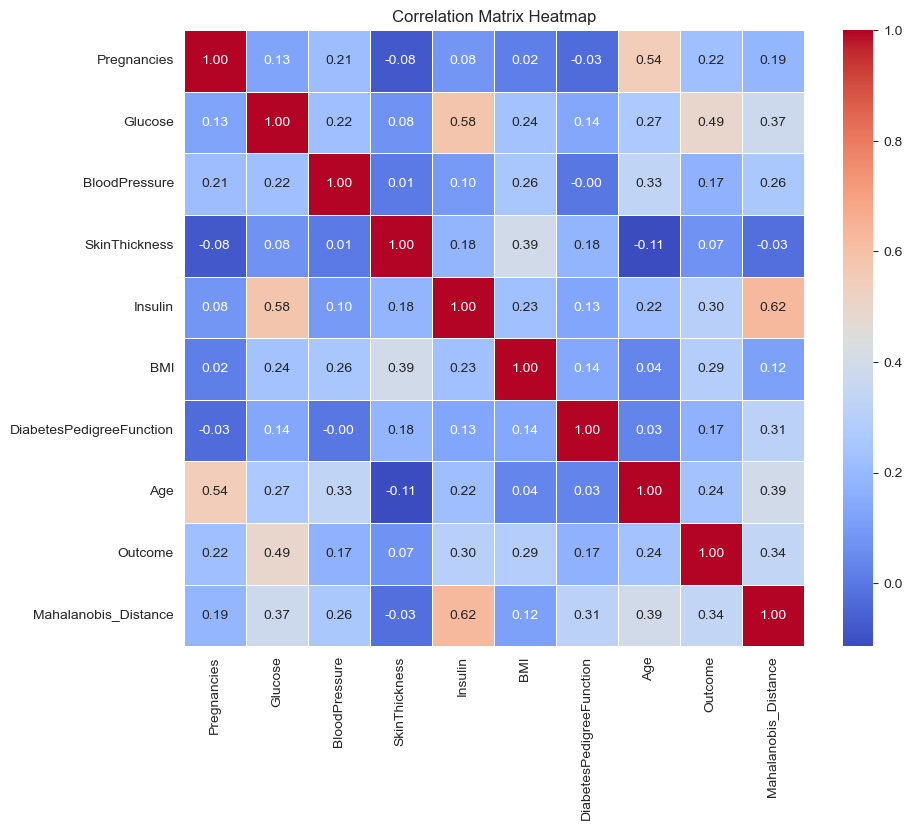

In [18]:
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()

correlation_matrix = df[num_vars].corr()

print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

#### Task B
Based on your Data Audit, prepare your data for further analysis by handling outliers and missing data.


In [23]:
df_cleaned = df[df['Multivariate_Outlier'] == False].copy()
#df_cleaned = df[~((df["Glucose"] == 0) | (df["Insulin"] == 0)  | (df["BloodPressure"] == 0))].dropna(subset=["Glucose", "Insulin", "BloodPressure"])
df_cleaned['BloodPressure'] = df_cleaned['BloodPressure'].replace(0, np.nan)
df_cleaned['Insulin'] = df_cleaned['Insulin'].replace(0, np.nan)
df_cleaned['Glucose'] = df_cleaned['Glucose'].replace(0, np.nan)
df_cleaned['SkinThickness'] = df_cleaned['SkinThickness'].replace(0, np.nan)
df_cleaned[["Glucose", "Insulin", "BloodPressure"]] = df_cleaned[["Glucose", "Insulin", "BloodPressure"]].fillna(df_cleaned.mean())

df_cleaned.to_csv('../data/diabetes_cleaned.csv', index=False)


#### Task C
Test different methods to sample training and test data from the dataset. Compare the sampled datasets based on the descriptive methods you have learned and evaluate which sampling method worked best.

In [22]:
from sklearn.model_selection import train_test_split

def compare_split(train, test):
    comparison = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Standard Deviation'],
        'Train': [train.mean().mean(), train.median().median(), train.std().mean()],
        'Test': [test.mean().mean(), test.median().median(), test.std().mean()]
    })
    print(comparison)

print("RANDOM SPLIT")
train, test = train_test_split(df, test_size=0.2, random_state=42)
compare_split(train, test)

print("STRATIFIED SPLIT")
train, test = train_test_split(df, test_size=0.2, stratify=df['Outcome'], random_state=42)
compare_split(train, test)



RANDOM SPLIT
            Statistic      Train       Test
0                Mean  40.095956  41.005220
1              Median  23.000000  26.000000
2  Standard Deviation  18.392358  18.499625
STRATIFIED SPLIT
            Statistic      Train       Test
0                Mean  39.678493  42.977590
1              Median  23.000000  22.000000
2  Standard Deviation  17.329032  22.278389
